# Contents

1. [Convert BC Shelter Addresses JSON to CSV](#1)
2. [Clean BC Shelter Addresses with PostalCode](#2)
3. [Clean BC Patient Addresses with PostalCode](#3)  
4. [Verify IsNonMarket Addresses](#4)
5. [Descriptive Analysis](#5)
    - 5.1 [Check Overlap Between PARIS and CERNER Patients](#5.1)
    - 5.2 [Compare Latest PARIS Postal vs. CERNER Postal](#5.2)
    - 5.3 [Postal Codes Frequency in CERNER](#5.3)
    - 5.4 [Address change frequency](#5.4)
    - 5.5 [Unique patients per address](#5.5)
    - 5.6 [Comparing Address Consistency Between CERNE‌R and PARIS ](#5.6)

### 1. Convert BC Shelter Addresses JSON to CSV<a id='1'></a>

In [ ]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install numpy

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
import pandas as pd
import json

json_path = "data/bc_shelter_addresses.json"
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.json_normalize(data)
address_column = df.loc[:, ['address_text']] if 'address_text' in df.columns else df.iloc[:, [0]]
address_column.columns = ['addressString']
# Save to CSV
csv_path = "data/bc_shelter_addresses.csv"
address_column.to_csv(csv_path, index=False, encoding='utf-8')

### 2. Clean BC Shelter Addresses with PostalCode <a id='2'></a>

In [2]:
import pandas as pd
import urllib.parse
import urllib.request
import xml.dom.minidom
import time

# --- Canada Post AddressComplete API functions ---
def find_address(Key, SearchTerm):
    base_url = "http://ws1.postescanada-canadapost.ca/AddressComplete/Interactive/Find/v2.10/xmla.ws?"
    params = {
        "Key": Key,
        "SearchTerm": SearchTerm,
        "Country": "CAN",
        "LanguagePreference": "EN",
        "MaxSuggestions": "1",
        "MaxResults": "1"
    }
    url = base_url + urllib.parse.urlencode(params)
    with urllib.request.urlopen(url) as response:
        xml_data = response.read()

    doc = xml.dom.minidom.parseString(xml_data)
    data_nodes = doc.getElementsByTagName("Row")

    if not data_nodes:
        return None

    id = data_nodes[0].getAttribute("Id")
    next_action = data_nodes[0].getAttribute("Next")

    # If 'Next' says 'Find', do another query
    while next_action == "Find":
        params = {
            "Key": Key,
            "SearchTerm": "",
            "LastId": id,
            "Country": "CAN",
            "LanguagePreference": "EN",
            "MaxSuggestions": "1",
            "MaxResults": "1"
        }
        url = base_url + urllib.parse.urlencode(params)
        with urllib.request.urlopen(url) as response:
            xml_data = response.read()

        doc = xml.dom.minidom.parseString(xml_data)
        data_nodes = doc.getElementsByTagName("Row")

        if not data_nodes:
            return None

        id = data_nodes[0].getAttribute("Id")
        next_action = data_nodes[0].getAttribute("Next")

    return id

def retrieve_address(Key, Id):
    base_url = "http://ws1.postescanada-canadapost.ca/AddressComplete/Interactive/Retrieve/v2.11/xmla.ws?"
    params = {
        "Key": Key,
        "Id": Id
    }
    url = base_url + urllib.parse.urlencode(params)
    with urllib.request.urlopen(url) as response:
        xml_data = response.read()
    doc = xml.dom.minidom.parseString(xml_data)
    schema_nodes = doc.getElementsByTagName("Column")
    data_nodes = doc.getElementsByTagName("Row")
    if not data_nodes:
        return None
    row = {
        col.getAttribute("Name"): data_nodes[0].getAttribute(col.getAttribute("Name"))
        for col in schema_nodes
    }
    return row.get("PostalCode", "")

# --- Step 1: Load and filter data ---
df = pd.read_csv("data/job-784641-result-1.csv")
filtered_df = df[df["precisionPoints"] >= 99].copy()
filtered_df = filtered_df.drop_duplicates(subset=["fullAddress"])

print(f"Filtered and deduplicated rows: {len(filtered_df)}")

filtered_df["civicNumber"] = filtered_df["civicNumber"].apply(
    lambda x: str(int(x)) if pd.notnull(x) and str(x).replace('.', '', 1).isdigit() else ""
)

#--- Step 2: Use AddressComplete API to get postal codes ---

#Sample size for testing
sample_size = 5  # change to X number or another number as needed
sample_df = filtered_df.sample(n=sample_size, random_state=42).copy()

display(sample_df)

api_key = "BK53-ME26-ZP55-XK78"
postal_codes = []

for addr in sample_df["fullAddress"]:
    try:
        id = find_address(api_key, addr)
        if id:
            postal = retrieve_address(api_key, id)
        else:
            postal = ""
    except Exception as e:
        postal = ""
    postal_codes.append(postal)
    time.sleep(0.2)  

sample_df["postalCode"] = postal_codes

# --- Step 3: Format final output ---
formatted_df = sample_df[[
    "unitNumber",
    "civicNumber",
    "streetName",
    "streetType",
    "streetDirection",
    "provinceCode",
    "localityName",
    "postalCode",
    "matchPrecision",
    "precisionPoints"
]].copy()

# --- Step 4: Export to Cleaned CSV ---
formatted_df.to_csv("data/bc_shelter_addresses_cleaned.csv", index=False)
print("File saved as: bc_shelter_addresses_cleaned.csv")
display(formatted_df.head(5))

Filtered and deduplicated rows: 201


,sequenceNumber,resultNumber,yourId,fullAddress,intersectionName,score,matchPrecision,precisionPoints,faults,siteName,...,intersectionID,fullSiteDescriptor,accessNotes,siteStatus,siteRetireDate,changeDate,isOfficial,degree,executionTime,sid
150,151,1,NaN,"268 Fulford-Ganges Rd, Salt Spring Island, BC",NaN,99,CIVIC_NUMBER,100,[PROVINCE.missing:1],NaN,...,NaN,NaN,"""",active,9999-12-31,2025-02-07,True,NaN,0.437,2892975.0
28,29,1,NaN,"108 E Hastings St, Vancouver, BC",NaN,99,CIVIC_NUMBER,100,[PROVINCE.missing:1],NaN,...,NaN,NaN,"""",active,9999-12-31,2025-02-07,True,NaN,1.443,4458023.0
50,51,1,NaN,"1240 Yates St, Victoria, BC",NaN,99,CIVIC_NUMBER,100,[PROVINCE.missing:1],NaN,...,NaN,NaN,"""",active,9999-12-31,2025-02-07,True,NaN,0.063,3039547.0
249,250,1,NaN,"5653 Wharf Ave, Sechelt, BC",NaN,99,CIVIC_NUMBER,100,[PROVINCE.missing:1],NaN,...,NaN,NaN,"""",active,9999-12-31,2025-02-07,True,NaN,0.083,4330127.0
203,204,1,NaN,"390 Main St, Vancouver, BC",NaN,99,CIVIC_NUMBER,100,[PROVINCE.missing:1],NaN,...,NaN,NaN,"""",active,9999-12-31,2025-02-07,True,NaN,0.084,3673792.0


File saved as: bc_shelter_addresses_cleaned.csv


,unitNumber,civicNumber,streetName,streetType,streetDirection,provinceCode,localityName,postalCode,matchPrecision,precisionPoints
150,NaN,268,Fulford-Ganges,Rd,NaN,BC,Salt Spring Island,,CIVIC_NUMBER,100
28,NaN,108,Hastings,St,E,BC,Vancouver,,CIVIC_NUMBER,100
50,NaN,1240,Yates,St,NaN,BC,Victoria,,CIVIC_NUMBER,100
249,NaN,5653,Wharf,Ave,NaN,BC,Sechelt,,CIVIC_NUMBER,100
203,NaN,390,Main,St,NaN,BC,Vancouver,,CIVIC_NUMBER,100


### 3. Clean BC Patient Addresses with PostalCode <a id='3'></a>

In [4]:
import pandas as pd
import urllib.parse
import urllib.request
import xml.dom.minidom
import time

# --- Canada Post AddressComplete API functions ---
def find_address(Key, SearchTerm):
    base_url = "http://ws1.postescanada-canadapost.ca/AddressComplete/Interactive/Find/v2.10/xmla.ws?"
    params = {
        "Key": Key,
        "SearchTerm": SearchTerm,
        "Country": "CAN",
        "LanguagePreference": "EN",
        "MaxSuggestions": "1",
        "MaxResults": "1"
    }
    url = base_url + urllib.parse.urlencode(params)
    with urllib.request.urlopen(url) as response:
        xml_data = response.read()

    doc = xml.dom.minidom.parseString(xml_data)
    data_nodes = doc.getElementsByTagName("Row")

    if not data_nodes:
        return None

    id = data_nodes[0].getAttribute("Id")
    next_action = data_nodes[0].getAttribute("Next")

    # If 'Next' says 'Find', do another query
    while next_action == "Find":
        params = {
            "Key": Key,
            "SearchTerm": "",
            "LastId": id,
            "Country": "CAN",
            "LanguagePreference": "EN",
            "MaxSuggestions": "1",
            "MaxResults": "1"
        }
        url = base_url + urllib.parse.urlencode(params)
        with urllib.request.urlopen(url) as response:
            xml_data = response.read()

        doc = xml.dom.minidom.parseString(xml_data)
        data_nodes = doc.getElementsByTagName("Row")

        if not data_nodes:
            return None

        id = data_nodes[0].getAttribute("Id")
        next_action = data_nodes[0].getAttribute("Next")

    return id

def retrieve_address(Key, Id):
    base_url = "http://ws1.postescanada-canadapost.ca/AddressComplete/Interactive/Retrieve/v2.11/xmla.ws?"
    params = {
        "Key": Key,
        "Id": Id
    }
    url = base_url + urllib.parse.urlencode(params)
    with urllib.request.urlopen(url) as response:
        xml_data = response.read()
    doc = xml.dom.minidom.parseString(xml_data)
    schema_nodes = doc.getElementsByTagName("Column")
    data_nodes = doc.getElementsByTagName("Row")
    if not data_nodes:
        return None
    row = {
        col.getAttribute("Name"): data_nodes[0].getAttribute(col.getAttribute("Name"))
        for col in schema_nodes
    }
    return row.get("PostalCode", "")

# --- Step 1: Load and filter data ---
df = pd.read_csv("data/job-787826-result-1.csv")
filtered_df = df[df["precisionPoints"] >= 99].copy()
filtered_df = filtered_df.drop_duplicates(subset=["fullAddress"])

print(f"Filtered and deduplicated rows: {len(filtered_df)}")

filtered_df["civicNumber"] = filtered_df["civicNumber"].apply(
    lambda x: str(int(x)) if pd.notnull(x) and str(x).replace('.', '', 1).isdigit() else ""
)

#--- Step 2: Use AddressComplete API to get postal codes ---

#Sample size for testing
# sample_size = 5  # change to X number or another number as needed
# sample_df = filtered_df.sample(n=sample_size, random_state=42).copy()

sample_df = filtered_df.copy()

api_key = "BK53-ME26-ZP55-XK78"
postal_codes = []

for addr in sample_df["fullAddress"]:
    try:
        id = find_address(api_key, addr)
        if id:
            postal = retrieve_address(api_key, id)
        else:
            postal = ""
    except Exception as e:
        postal = ""
    postal_codes.append(postal)
    time.sleep(0.2)  

sample_df["postalCode"] = postal_codes

# --- Step 3: Format final output ---
formatted_df = sample_df[[
    "unitNumber",
    "civicNumber",
    "streetName",
    "streetType",
    "streetDirection",
    "provinceCode",
    "localityName",
    "postalCode",
    "matchPrecision",
    "precisionPoints"
]].copy()

# --- Step 4: Export to Cleaned CSV ---
formatted_df.to_csv("data/bc_patient_addresses_cleaned.csv", index=False)
print("File saved as: bc_patient_addresses_cleaned.csv")
display(formatted_df.head(5))

Filtered and deduplicated rows: 42
File saved as: bc_patient_addresses_cleaned.csv


,unitNumber,civicNumber,streetName,streetType,streetDirection,provinceCode,localityName,postalCode,matchPrecision,precisionPoints
0,NaN,1000,Burrard,St,NaN,BC,Vancouver,,CIVIC_NUMBER,100
1,NaN,1014,Homer,St,NaN,BC,Vancouver,,CIVIC_NUMBER,100
2,NaN,1016,Alberni,St,NaN,BC,Vancouver,,CIVIC_NUMBER,100
3,NaN,1018,Granville,St,NaN,BC,Vancouver,,CIVIC_NUMBER,100
4,NaN,1040,Georgia,St,W,BC,Vancouver,,CIVIC_NUMBER,100


### 4. Verify IsNonMarket Addresses <a id='4'></a>

In [5]:
patient_df = pd.read_csv("data/bc_patient_addresses_cleaned.csv")
shelter_df = pd.read_csv("data/bc_shelter_addresses_cleaned.csv")

def build_full_address_string(df):
    return (
        df["unitNumber"].fillna("").astype(str).str.strip() + " " +
        df["civicNumber"].fillna("").astype(str).str.strip() + " " +
        df["streetDirection"].fillna("").astype(str).str.strip() + " " +
        df["streetName"].fillna("").astype(str).str.strip() + " " +
        df["streetType"].fillna("").astype(str).str.strip() + ", " +
        df["localityName"].fillna("").astype(str).str.strip() + ", " +
        df["provinceCode"].fillna("").astype(str).str.strip() + ", " +
        df["postalCode"].fillna("").astype(str).str.strip()
    ).str.replace(" +", " ", regex=True).str.lower().str.strip()

# Generate address strings
patient_df["addressString"] = build_full_address_string(patient_df)
shelter_df["addressString"] = build_full_address_string(shelter_df)

# Compare and label matches
shelter_set = set(shelter_df["addressString"])
patient_df["Match"] = patient_df["addressString"].apply(lambda x: "Yes" if x in shelter_set else "No")

# Save to CSV
patient_df.to_csv("data/isnonmarket_addresses.csv", index=False)
print("File saved as: isnonmarket_addresses.csv")
display(patient_df.head(5))

File saved as: isnonmarket_addresses.csv


,unitNumber,civicNumber,streetName,streetType,streetDirection,provinceCode,localityName,postalCode,matchPrecision,precisionPoints,addressString,Match
0,NaN,1000,Burrard,St,NaN,BC,Vancouver,NaN,CIVIC_NUMBER,100,"1000 burrard st, vancouver, bc,",No
1,NaN,1014,Homer,St,NaN,BC,Vancouver,NaN,CIVIC_NUMBER,100,"1014 homer st, vancouver, bc,",No
2,NaN,1016,Alberni,St,NaN,BC,Vancouver,NaN,CIVIC_NUMBER,100,"1016 alberni st, vancouver, bc,",No
3,NaN,1018,Granville,St,NaN,BC,Vancouver,NaN,CIVIC_NUMBER,100,"1018 granville st, vancouver, bc,",No
4,NaN,1040,Georgia,St,W,BC,Vancouver,NaN,CIVIC_NUMBER,100,"1040 w georgia st, vancouver, bc,",No


### 5. Descriptive Analysis <a href='5'></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the PARIS dataset (1st dataset)
paris_df = pd.read_csv("data/paris_df.csv", parse_dates=["start_date", "end_date"])

# Load the CERNER dataset (3rd dataset)
cerner_df = pd.read_csv("data/cerner_df.csv")

#### 5.1 Check Overlap Between PARIS and CERNER Patients <a href='5.1'></a>

In [7]:
# Number of patients in each dataset
n_paris = paris_df["patient_id"].nunique()
n_cerner = cerner_df["patient_id"].nunique()
n_common = len(set(paris_df["patient_id"]) & set(cerner_df["patient_id"]))

print(f"🧍 Unique patients in PARIS: {n_paris}")
print(f"🧍 Unique patients in CERNER: {n_cerner}")
print(f"🔁 Patients in both datasets: {n_common}")

🧍 Unique patients in PARIS: 43
🧍 Unique patients in CERNER: 20
🔁 Patients in both datasets: 20


#### 5.2 Compare Latest PARIS Postal vs. CERNER Postal <a href='5.2'></a>

In [8]:
# Get latest postalCode from PARIS
latest_paris_postals = (
    paris_df.sort_values(by=["patient_id", "start_date"])
    .groupby("patient_id").tail(1)[["patient_id", "postalCode"]]
    .rename(columns={"postalCode": "paris_postalCode"})
)

# Merge with CERNER
merged = cerner_df.merge(latest_paris_postals, on="patient_id", how="left")
merged["postal_match"] = merged["postalCode"] == merged["paris_postalCode"]

# Postal match summary
postal_match_rate = merged["postal_match"].mean() * 100
print(f"Postal code match rate between PARIS and CERNER: {postal_match_rate:.2f}%")

postal_mismatch = merged[merged["postal_match"] == False]


Postal code match rate between PARIS and CERNER: 37.04%


#### 5.3 Postal Codes Frequency in CERNER <a href='5.3'></a>

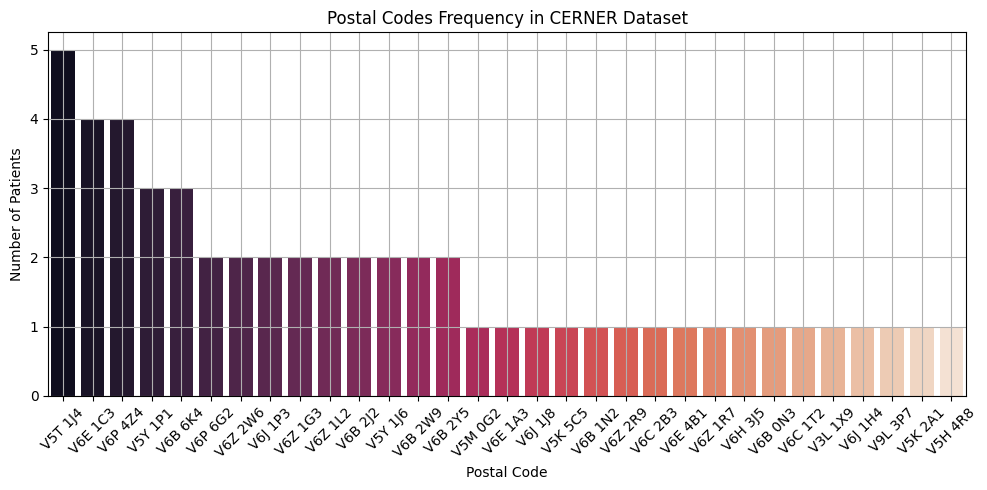

In [9]:
cerner_postals = cerner_df["postalCode"].value_counts()
# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=cerner_postals.index, y=cerner_postals.values, palette="rocket")

plt.title("Postal Codes Frequency in CERNER Dataset")
plt.xlabel("Postal Code")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### 5.4 Address change frequency <a href='5.4'></a>


Blank address rows: 0 / 96 (0.00%)


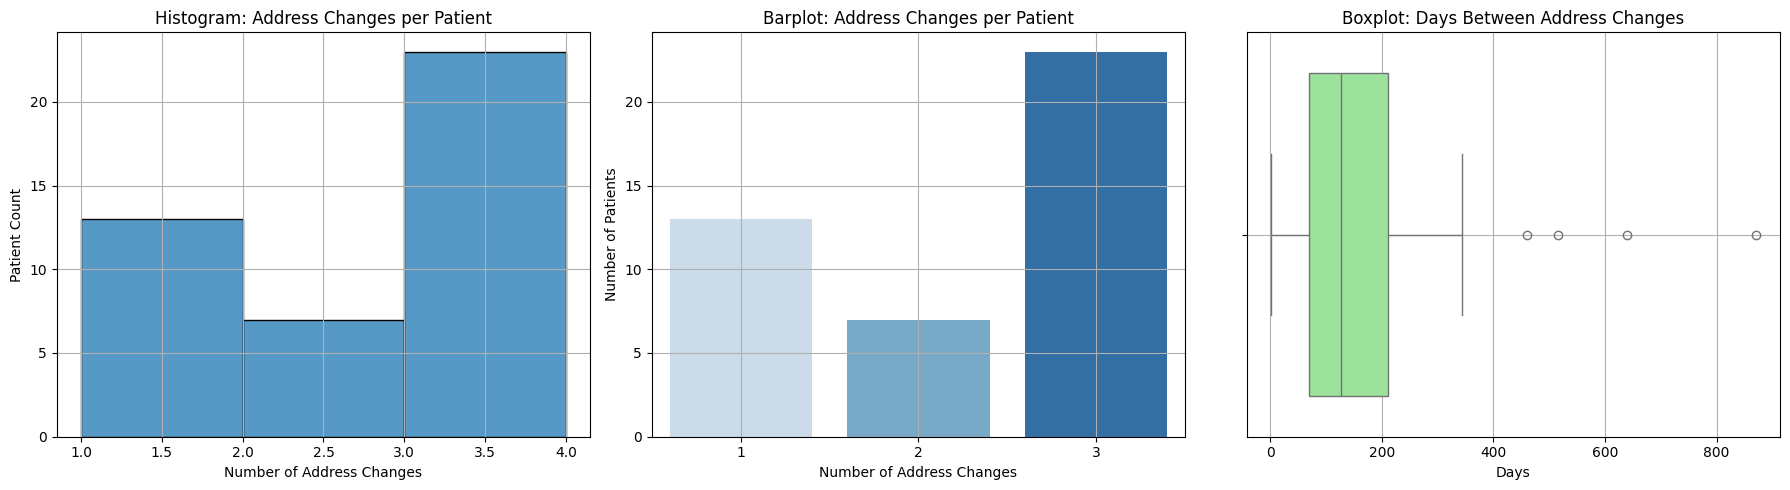

In [10]:

# Count how many times each patient changed address
address_change_counts = paris_df.groupby("patient_id").size().reset_index(name="address_changes")

# Sort and calculate duration between address changes (in days)
paris_df_sorted = paris_df.sort_values(by=["patient_id", "start_date"])
paris_df_sorted["prev_start"] = paris_df_sorted.groupby("patient_id")["start_date"].shift()
paris_df_sorted["days_between"] = (paris_df_sorted["start_date"] - paris_df_sorted["prev_start"]).dt.days

# Frequency of blank address fields (based on full address string)
paris_df["full_address"] = (
    paris_df["unitNumber"].fillna("").astype(str).str.strip() + " " +
    paris_df["civicNumber"].fillna("").astype(str).str.strip() + " " +
    paris_df["streetDirection"].fillna("").astype(str).str.strip() + " " +
    paris_df["streetName"].fillna("").astype(str).str.strip() + " " +
    paris_df["streetType"].fillna("").astype(str).str.strip() + ", " +
    paris_df["localityName"].fillna("").astype(str).str.strip() + ", " +
    paris_df["provinceCode"].fillna("").astype(str).str.strip() + ", " +
    paris_df["postalCode"].fillna("").astype(str).str.strip()
).str.replace(" +", " ", regex=True).str.lower().str.strip()

blank_count = (paris_df["full_address"] == "").sum()
print(f"\nBlank address rows: {blank_count} / {len(paris_df)} ({100 * blank_count / len(paris_df):.2f}%)")

# Create a horizontal layout with 3 plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# --- Plot 1: Histogram of address change frequency ---
sns.histplot(address_change_counts["address_changes"], bins=range(1, 5), edgecolor='black', ax=axes[0])
axes[0].set_title("Histogram: Address Changes per Patient")
axes[0].set_xlabel("Number of Address Changes")
axes[0].set_ylabel("Patient Count")
axes[0].grid(True)

# --- Plot 2: Bar chart of address change frequency ---
sns.countplot(x="address_changes", data=address_change_counts, palette="Blues", ax=axes[1])
axes[1].set_title("Barplot: Address Changes per Patient")
axes[1].set_xlabel("Number of Address Changes")
axes[1].set_ylabel("Number of Patients")
axes[1].grid(True)

# --- Plot 3: Boxplot of days between address changes ---
sns.boxplot(x=paris_df_sorted["days_between"].dropna(), color="lightgreen", ax=axes[2])
axes[2].set_title("Boxplot: Days Between Address Changes")
axes[2].set_xlabel("Days")
axes[2].grid(True)

# Tidy up layout
plt.tight_layout()
plt.show()



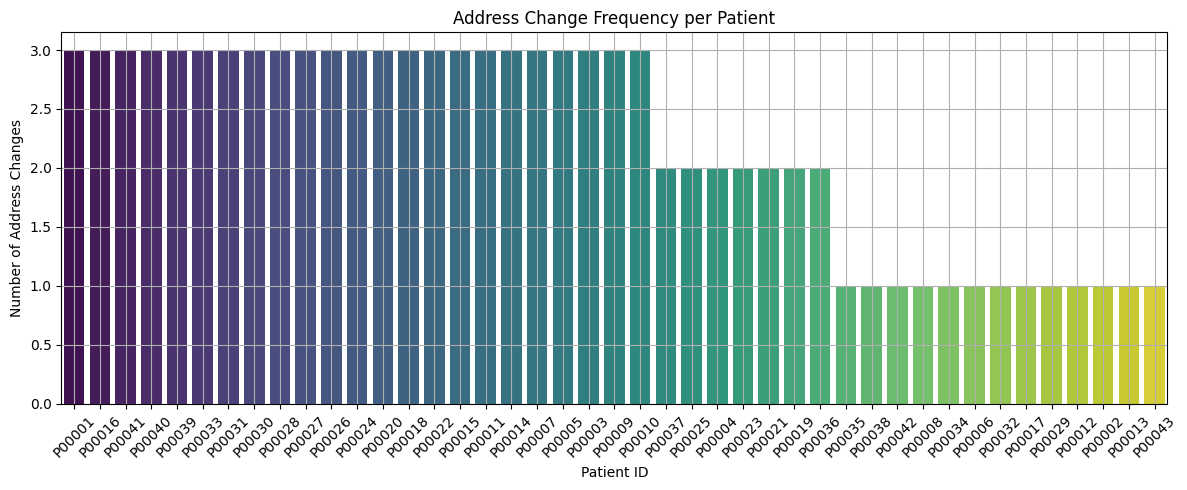

In [11]:
# Count and sort address changes per patient
address_change_counts = paris_df.groupby("patient_id").size().reset_index(name="address_changes")
top_mobile_patients = address_change_counts.sort_values(by="address_changes", ascending=False)

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x="patient_id", y="address_changes", data=top_mobile_patients, palette="viridis")

plt.title("Address Change Frequency per Patient")
plt.xlabel("Patient ID")
plt.ylabel("Number of Address Changes")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Finding:
- 15 patients are highly mobile, 9 patients are morderate and 18 patients are stable (1 address).
- Among those who move, they do so every ~3–6 months.

#### 5.5 Unique patients per address <a href='5.5'></a>


Top Shared Addresses by Number of Unique Patients:
                                      full_address  unique_patients
11          1564 w 6th ave, vancouver, bc, v5t 1j4                6
33       8038 granville st, vancouver, bc, v6p 4z4                5
7           1225 robson st, vancouver, bc, v6e 1c3                5
29       675 w hastings st, vancouver, bc, v6b 1n2                3
28           654 nelson st, vancouver, bc, v6b 6k4                3
19       2832 granville st, vancouver, bc, v6h 3j5                3
15         175 e broadway , vancouver, bc, v5y 1p1                3
14  1706 trans-canada hwy, kanaka bar, bc, v9l 3p7                3
12         1666 w 75th ave, vancouver, bc, v6p 6g2                3
17          1836 w 5th ave, vancouver, bc, v6j 1p3                3
10          1535 w 3rd ave, vancouver, bc, v6j 1j8                2
21    300.0 1622 w 7th ave, vancouver, bc, v5m 0g2                2
32        736 granville st, vancouver, bc, v6z 1g3              

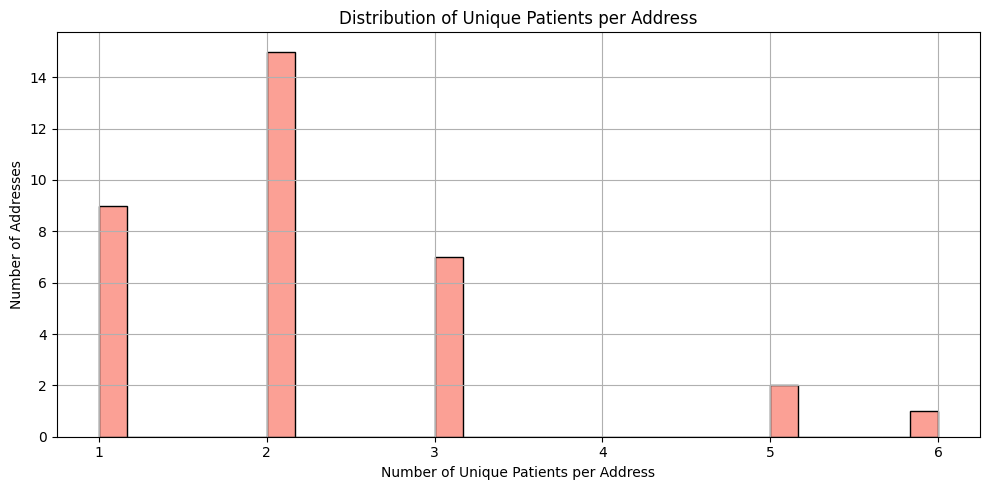

In [12]:
patients_per_address = paris_df.groupby("full_address")["patient_id"].nunique().reset_index(name="unique_patients")
top_shared_addresses = patients_per_address.sort_values(by="unique_patients", ascending=False)

print("\nTop Shared Addresses by Number of Unique Patients:")
print(top_shared_addresses)

# Unique addresses per patient
addresses_per_patient = paris_df.groupby("patient_id")["full_address"].nunique().reset_index(name="unique_addresses")
top_mobile_patients = addresses_per_patient.sort_values(by="unique_addresses", ascending=False)

print("\n Most Mobile Patients by Number of Unique Addresses:")
print(top_mobile_patients)

#Calculate number of unique patients per address
patients_per_address = paris_df.groupby("full_address")["patient_id"].nunique().reset_index(name="unique_patients")

# Histogram of address sharing
plt.figure(figsize=(10, 5))
sns.histplot(patients_per_address["unique_patients"], bins=30, kde=False, color="salmon")
plt.title("Distribution of Unique Patients per Address")
plt.xlabel("Number of Unique Patients per Address")
plt.ylabel("Number of Addresses")
plt.grid(True)
plt.tight_layout()
plt.show()



Finding:
- Most addresses (11) are linked to a single patient, suggesting stable housing situations.
- 14 addresses are associated with two patients, which may still reflect typical residential sharing (e.g., family or roommates).
- A smaller subset of addresses are shared by 3 to 6 unique patients, which raises concern about individuals experiencing housing instability or homelessness.

#### 5.6 Comparing Address Consistency Between PARIS and CERNER <a href='5.6'></a>

1. Compare Postal Codes
- If overlap exists:
	- Exact Match → Full postal codes match
	- FSA Match → First 3 characters (FSA) match (Forward Sortation Area)
- If no match, label as Unverifiable

2. Assign Confidence Scores

| Match Type    | Score | Confidence Level   |
|---------------|--------|--------------------|
| Exact Match   | 2      | High Confidence    |
| FSA Match     | 1      | Medium Confidence  |
| No match      | 0      | Unverifiable	      |

3. Analyze Results
- Summarize match types and confidence scores
- Identify patterns of alignment or discrepancy across both datasets
- Use results to assess consistency and completeness of address data over time.

In [27]:
import pandas as pd

# --- Step 1: Load datasets ---
paris_df = pd.read_csv("data/paris_df.csv")
cerner_df = pd.read_csv("data/cerner_df.csv")

# --- Step 2: Extract FSA ---
def get_fsa(postal):
    return str(postal).replace(" ", "")[:3] if pd.notna(postal) else None

paris_df["fsa"] = paris_df["postalCode"].apply(get_fsa)
cerner_df["fsa"] = cerner_df["postalCode"].apply(get_fsa)

# --- Step 3: Prepare results ---
combined_records = []

# --- Step 4: CERNE‌R → PARIS Comparison (postal only) ---
for pid in cerner_df["patient_id"].unique():
    cerner_p = cerner_df[cerner_df["patient_id"] == pid]
    paris_p = paris_df[paris_df["patient_id"] == pid]

    # For Cerner → Paris, if no Paris records
    if paris_p.empty:
        for _, c_row in cerner_p.iterrows():
            combined_records.append({
                "direction": "CERNER → PARIS",
                "patient_id": pid,
                "cerner_postal": c_row["postalCode"],
                "paris_postal": None,
                "match_type": "No Match",
                "confidence_score": 0,
                "confidence_label": "Unverifiable"
            })
        continue

    for _, c_row in cerner_p.iterrows():
        c_postal, c_fsa = c_row["postalCode"], c_row["fsa"]

        # Check for exact match
        if c_postal in paris_p["postalCode"].values:
            match_type = "Exact Match"
            score = 2
            label = "High Confidence"
            paris_postal = c_postal
        elif c_fsa in paris_p["fsa"].values:
            match_type = "FSA Match"
            score = 1
            label = "Medium Confidence"
            paris_postal = paris_p[paris_p["fsa"] == c_fsa]["postalCode"].iloc[0]
        else:
            match_type = "No Match"
            score = 0
            label = "Unverifiable"
            paris_postal = None

        combined_records.append({
            "direction": "CERNER → PARIS",
            "patient_id": pid,
            "cerner_postal": c_postal,
            "paris_postal": paris_postal,
            "match_type": match_type,
            "confidence_score": score, 
            "confidence_label": label
        })

# --- Step 5: PARIS → CERNE‌R Comparison (postal only) ---
for pid in paris_df["patient_id"].unique():
    paris_p = paris_df[paris_df["patient_id"] == pid]
    cerner_p = cerner_df[cerner_df["patient_id"] == pid]

    # For Paris → Cerner, if no Cerner records
    if cerner_p.empty:
        for _, p_row in paris_p.iterrows():
            combined_records.append({
                "direction": "PARIS → CERNER",
                "patient_id": pid,
                "paris_postal": p_row["postalCode"],
                "cerner_postal": None,
                "match_type": "No Match",
                "confidence_score": 0,
                "confidence_label": "Unverifiable"
            })
        continue

    for _, p_row in paris_p.iterrows():
        p_postal, p_fsa = p_row["postalCode"], p_row["fsa"]

        if p_postal in cerner_p["postalCode"].values:
            match_type = "Exact Match"
            score = 2
            label = "High Confidence"
            cerner_postal = p_postal
        elif p_fsa in cerner_p["fsa"].values:
            match_type = "FSA Match"
            score = 1
            label = "Medium Confidence"
            cerner_postal = cerner_p[cerner_p["fsa"] == p_fsa]["postalCode"].iloc[0]
        else:
            match_type = "No Match"
            score = 0
            label = "Unverifiable"
            cerner_postal = None

        combined_records.append({
            "direction": "PARIS → CERNER",
            "patient_id": pid,
            "paris_postal": p_postal,
            "cerner_postal": cerner_postal,
            "match_type": match_type,
            "confidence_score": score,
            "confidence_label": label
        })

# --- Step 6: Final DataFrame ---
combined_df = pd.DataFrame(combined_records)
combined_df

combined_df.to_csv("data/combined_df.csv", index=False)

In [35]:
# Summary

print("📊 Match Type Counts:")
print(combined_df["match_type"].value_counts())
print("\n✅ Confidence Level Distribution:")
print(combined_df["confidence_label"].value_counts())
print(f"\n📈 Overall Match Rate (score ≥ 1): {(combined_df['confidence_score'] >= 1).mean():.2%}")


📊 Match Type Counts:
match_type
Exact Match    126
No Match        21
FSA Match        2
Name: count, dtype: int64

✅ Confidence Level Distribution:
confidence_label
High Confidence      126
Unverifiable          21
Medium Confidence      2
Name: count, dtype: int64

📈 Overall Match Rate (score ≥ 1): 85.91%


#### Visualization

/var/folders/96/zkx_7hk579v922k6dk_fc26c0000gn/T/ipykernel_96681/94496320.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="match_type", data=combined_df, ax=axes[0], palette="Set2",


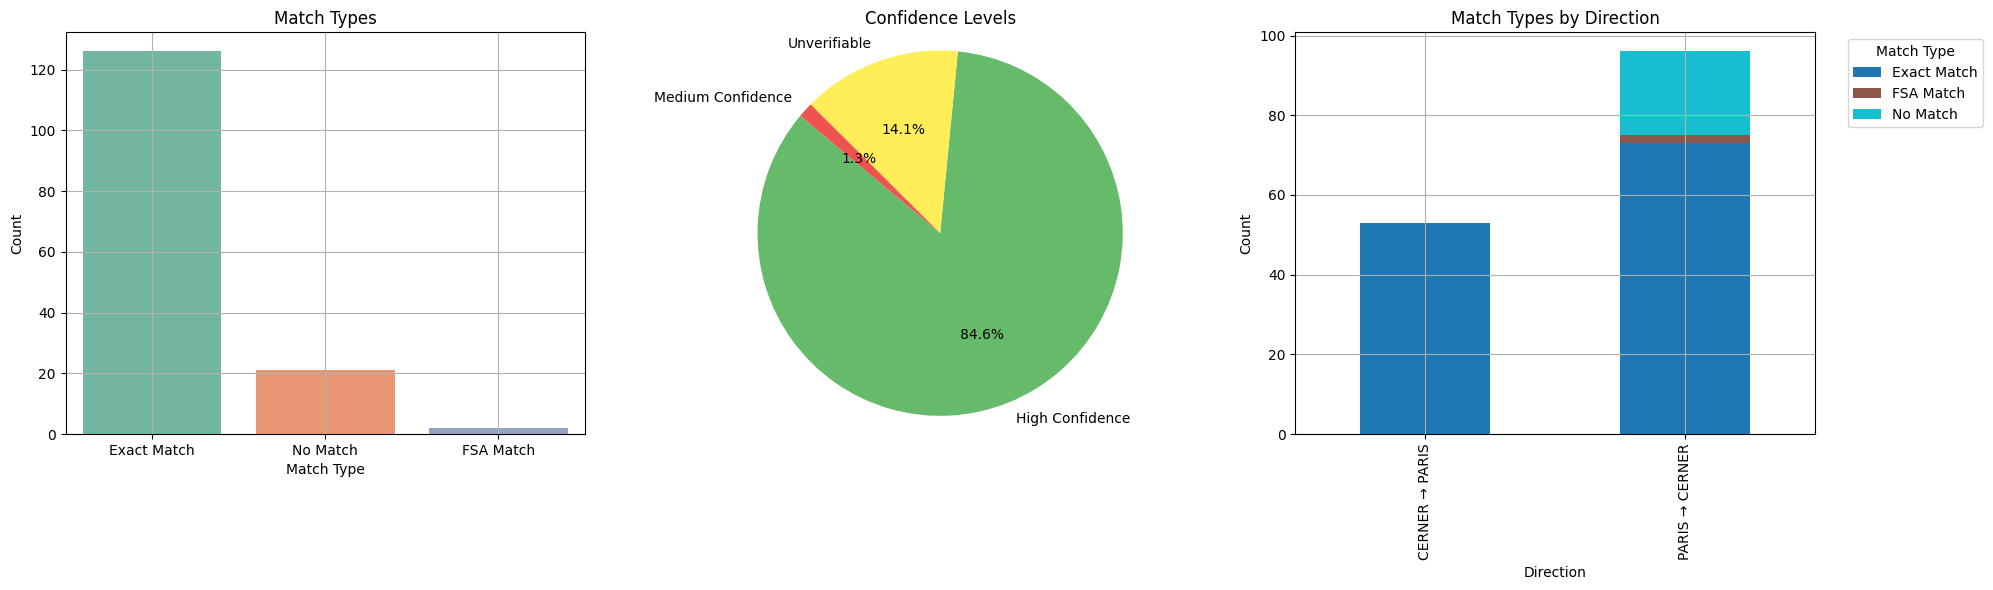

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# --- Plot 1: Match Type Distribution ---
sns.countplot(x="match_type", data=combined_df, ax=axes[0], palette="Set2",
              order=combined_df["match_type"].value_counts().index)
axes[0].set_title("Match Types")
axes[0].set_xlabel("Match Type")
axes[0].set_ylabel("Count")
axes[0].grid(True)

# --- Plot 2: Confidence Levels ---
confidence_counts = combined_df["confidence_label"].value_counts()
axes[1].pie(confidence_counts, labels=confidence_counts.index,
            autopct='%1.1f%%', startangle=140,
            colors=["#66bb6a", "#ffee58", "#ef5350", "#b0bec5"])
axes[1].set_title("Confidence Levels")
axes[1].axis("equal")

# --- Plot 3: Match Types by Direction ---
direction_match = combined_df.groupby(["direction", "match_type"]).size().unstack(fill_value=0)
direction_match.plot(kind='bar', stacked=True, ax=axes[2], colormap='tab10')
axes[2].set_title("Match Types by Direction")
axes[2].set_xlabel("Direction")
axes[2].set_ylabel("Count")
axes[2].legend(title="Match Type", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[2].grid(True)

# Tidy layout
plt.tight_layout()
plt.show()

How long does each patient stay at each address? (Community health data - Paris Dataset)

 

In [40]:
import numpy as np
# --- Reload the uploaded data ---
paris_df = pd.read_csv("data/paris_df.csv", parse_dates=["start_date", "end_date"])

# Step 1: Sort by patient and start date
paris_df_sorted = paris_df.sort_values(by=["patient_id", "start_date"]).copy()

# Step 2: Determine next start date per patient
paris_df_sorted["next_start_date"] = paris_df_sorted.groupby("patient_id")["start_date"].shift(-1)

# Step 3: Adjusted end date
paris_df_sorted["adjusted_end"] = paris_df_sorted["next_start_date"].combine_first(paris_df_sorted["end_date"])

# Step 4: Calculate total stay days
paris_df_sorted["total_stay_days"] = (
    (paris_df_sorted["adjusted_end"] - paris_df_sorted["start_date"]).dt.days
).clip(lower=1)

# Step 5: Build full address string
paris_df_sorted["full_address"] = (
    paris_df_sorted["unitNumber"].fillna("").astype(str).str.strip() + " " +
    paris_df_sorted["civicNumber"].astype(str).str.strip() + " " +
    paris_df_sorted["streetDirection"].fillna("").astype(str).str.strip() + " " +
    paris_df_sorted["streetName"].astype(str).str.strip() + " " +
    paris_df_sorted["streetType"].fillna("").astype(str).str.strip() + ", " +
    paris_df_sorted["localityName"].astype(str).str.strip() + ", " +
    paris_df_sorted["provinceCode"].astype(str).str.strip() + ", " +
    paris_df_sorted["postalCode"].astype(str).str.strip()
).str.replace(" +", " ", regex=True).str.lower().str.strip()

# Step 6: Summarize total stay days by patient and address
stay_summary = paris_df_sorted.groupby(
    ["patient_id", "full_address"]
)[["total_stay_days"]].sum().reset_index()

# Step 7: Prepare result_table
result_table = paris_df_sorted[[
    "patient_id", "full_address", "start_date", "next_start_date", "total_stay_days"
]].sort_values(by=["patient_id", "start_date"])

result_table["next_start_date"] = result_table["next_start_date"].dt.strftime("%Y-%m-%d")
result_table["next_start_date"] = result_table["next_start_date"].fillna("Not Available")

# --- Rebuild address change and stay summary ---

# Count unique addresses per patient
address_changes = paris_df_sorted.groupby("patient_id")["full_address"].nunique().reset_index()
address_changes.columns = ["patient_id", "unique_addresses"]

# Average stay per patient
avg_stay = stay_summary.groupby("patient_id")["total_stay_days"].mean().reset_index()
avg_stay.columns = ["patient_id", "avg_stay_days"]

# Merge
address_change_summary = address_changes.merge(avg_stay, on="patient_id")

result_table

,patient_id,full_address,start_date,next_start_date,total_stay_days
0,P00001,"725 granville st, vancouver, bc, v6z 1l2",2021-01-22 11:00:00,2021-03-31,67
1,P00001,"2832 granville st, vancouver, bc, v6h 3j5",2021-03-31 09:00:00,2021-05-24,53
2,P00001,"2889 e hastings st, vancouver, bc, v5k 2a1",2021-05-24 03:00:00,Not Available,1
3,P00002,"355 kingsway , vancouver, bc, v5t 3j7",2021-05-13 07:00:00,Not Available,1
4,P00003,"1706 trans-canada hwy, kanaka bar, bc, v9l 3p7",2021-02-10 10:00:00,2021-04-23,71
...,...,...,...,...,...
91,P00041,"475 howe st, vancouver, bc, v6c 2b3",2021-07-29 03:00:00,2022-01-11,166
92,P00041,"1564 w 6th ave, vancouver, bc, v5t 1j4",2022-01-11 04:00:00,2022-04-25,104
93,P00041,"175 e broadway , vancouver, bc, v5y 1p1",2022-04-25 04:00:00,Not Available,1
94,P00042,"2832 granville st, vancouver, bc, v6h 3j5",2022-06-10 07:00:00,Not Available,1


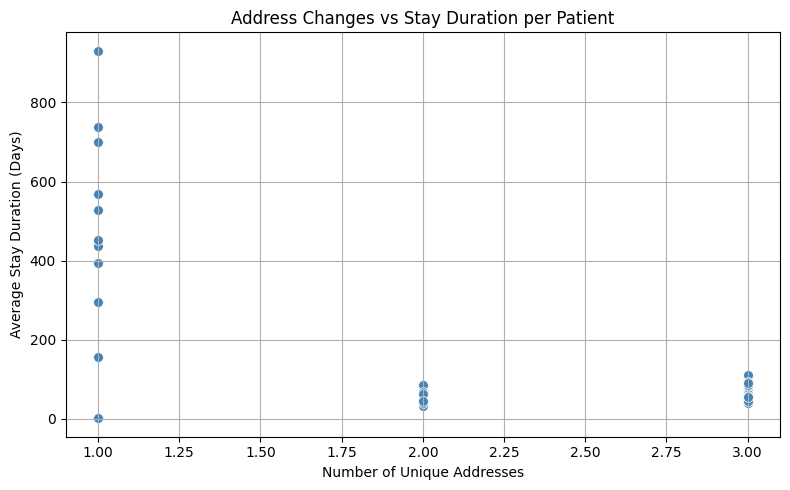

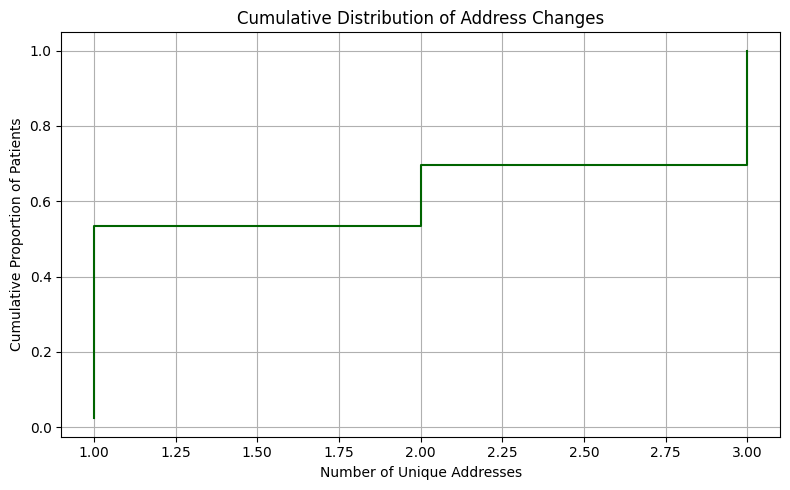

In [51]:
# --- Plot 1: Scatter Plot ---
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="unique_addresses",
    y="avg_stay_days",
    data=address_change_summary,
    s=50,
    color="steelblue"
)
plt.xlabel("Number of Unique Addresses")
plt.ylabel("Average Stay Duration (Days)")
plt.title("Address Changes vs Stay Duration per Patient")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: CDF ---
address_changes_sorted = address_changes.sort_values("unique_addresses").reset_index(drop=True)
address_changes_sorted["cumulative"] = (np.arange(1, len(address_changes_sorted) + 1)) / len(address_changes_sorted)

plt.figure(figsize=(8, 5))
plt.step(
    address_changes_sorted["unique_addresses"],
    address_changes_sorted["cumulative"],
    where="post",
    color="darkgreen"
)
plt.xlabel("Number of Unique Addresses")
plt.ylabel("Cumulative Proportion of Patients")
plt.title("Cumulative Distribution of Address Changes")
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# Step 1: Count unique addresses per patient per year
paris_df_sorted["year"] = paris_df_sorted["start_date"].dt.year

address_changes_yearly = paris_df_sorted.groupby(["patient_id", "year"])["full_address"].nunique().reset_index()
address_changes_yearly.columns = ["patient_id", "year", "unique_addresses"]

# Step 2: Filter where unique_addresses >= 3 in any year
potential_result = address_changes_yearly[address_changes_yearly["unique_addresses"] >= 3]

# Step 3: Sum total unique_addresses in qualifying years
total_changes = potential_result.groupby("patient_id")["unique_addresses"].sum().reset_index()
total_changes.columns = ["patient_id", "total_address_changes"]

# Step 4: View the result
print("Total address changes per patient with 3+ unique addresses in any year:")
total_changes



Total address changes per patient with 3+ unique addresses in any year:


,patient_id,total_address_changes
0,P00001,3
1,P00003,3
2,P00018,3
3,P00022,3
4,P00024,3
